# Задание: 
Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.
Вам поставлена задача создать такую модель.

In [157]:
import numpy as np 
import pandas as pd 

from collections import Counter # для подсчёта количества одинаковых значений в списке

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import category_encoders as ce # импорт для работы с кодировщиком

# для оценки эмоциональной окраски отзывов, а также для подготовки текста к этой оценке
import nltk
nltk.downloader.download('vader_lexicon')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

# для оценки значимости категориальных признаков
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# для машинного обучения
from sklearn.model_selection import train_test_split # инструмент для разделения датасета
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\litpo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\litpo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [158]:
# Сбрасываем ограничения, чтобы при выводе видеть полее полный датасет 

# Сброс ограничений на число столбцов в выводе
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_row', None)
# Сброс ограничений на количество выводимых строк

In [159]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимыми
RANDOM_SEED = 42

In [160]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимыми:
!pip freeze > requirements.txt

In [161]:
# читаем наши данные из предоставленных файлов
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

In [162]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [163]:
df_train.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671


In [164]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [165]:
df_test.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102


In [166]:
sample_submission.head(1)

,reviewer_score,id
0,8.651,488440


In [167]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [168]:
# перед обработкой признаков объединяем train и test в один датасет

df_train['sample'] = 1 # помечаем, где у нас train
df_test['sample'] = 0 # помечаем, где у нас test
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score (мы его должны предсказать), поэтому пока просто заполняем его нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\litpo\AppData\Local\Temp\ipykernel_9572\2432443667.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [169]:
"""# посмотрим на структуру столбцов (изолировано от кода для экономии места)

# создаём пустой список
unique_list = []
# пробегаемся по именам столбцов в таблице
for col in hotels.columns:
    # создаём кортеж (имя столбца, число уникальных значений, тип столбца, уникальные значения)
    item = (col, hotels[col].nunique(), hotels[col].dtypes, hotels[col].unique()) 
    # добавляем кортеж в список
    unique_list.append(item) 
# создаём вспомогательную таблицу и сортируем её по количеству уникальных значений в столбце
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type', 'Uniq_Values']
).sort_values(by='Num_Unique',  ignore_index=True)"""

"# посмотрим на структуру столбцов (изолировано от кода для экономии места)\n\n# создаём пустой список\nunique_list = []\n# пробегаемся по именам столбцов в таблице\nfor col in hotels.columns:\n    # создаём кортеж (имя столбца, число уникальных значений, тип столбца, уникальные значения)\n    item = (col, hotels[col].nunique(), hotels[col].dtypes, hotels[col].unique()) \n    # добавляем кортеж в список\n    unique_list.append(item) \n# создаём вспомогательную таблицу и сортируем её по количеству уникальных значений в столбце\nunique_counts = pd.DataFrame(\n    unique_list,\n    columns=['Column_Name', 'Num_Unique', 'Type', 'Uniq_Values']\n).sort_values(by='Num_Unique',  ignore_index=True)"

Поработам с признаками. Поскольку нам известно, что данные сравнительно "чистые", то избавлять от выбросов и т.д. мы не будем и сразу перейдём к следующим шагам:

1) найдём столбцы с пропусками в данных - это информация о географических координатах (lat, lng). В настоящем анализе эти признаки не используются, поэтому можно пропустить этап заполнения пропусков и просто удалить координаты

2) посмотрим на данные типа object: 
- удалим столбец с национальностью постояльца
- из адреса отеля выделим самое важное - страну и город (поместим их в новые признаки, исходный удалим), потом закодируем их (столбец с изначальным адресом удалим)
- среди названий отелей выделим 15 самых распространённых и закодируем их
- из даты отзыва и количества дней с публикации отзыва мы выделим год публикации отзыва и число дней (приведём столбец к int), год затем закодируем
- из тегов мы выделим самые распространённые 15 значений и закодируем их
- из признака с негативной и позитивной частями отзыва (negative_review и positive_review) получим преобразованные признаки, содержащие численную оценку эмоциональной окраски отзыва 

3) посмотрим на распределение признаков с числовыми значениями. Если будет нужно, то преобразуем их

1Й ШАГ

In [170]:
# убираем географические координаты
data = data.drop(['lat'], axis=1)
data = data.drop(['lng'], axis=1)

2Й ШАГ

In [171]:
# удаляем национальность постояльца
data = data.drop('reviewer_nationality', axis=1)


# обрабатываем адрес

# 1. выделим названия стран

# поскольку мы точно не знаем, сколько слов в названии страны, мы воспользуемся внешними данными
# список европейских стран (а из предварительного анализа данных можно узнать, что мы изучаем в датасете содержится информация именно 
# о европейских отелях) мы возьмём с сайта https://u-karty.ru/russia/countries-europe-stolicy-english.html?ysclid=lhys2eyjg2778859112, 
# но при желании можно использовать более полные и авторитетные источники

countries_list = [
    'Austria', 'Albania', 'Austria', 'Albania', 'Andorra', 'Belarus', 'Belgium', 'Bulgaria', 'Bosnia and Herzegovina', 
    'Vatican', 'United Kingdom', 'Hungary', 'Germany', 'Greece', 'Denmark', 'Ireland', 'Iceland', 'Spain', 'Italy', 
    'Kosovo', 'Latvia', 'Lithuania', 'Liechtenstein', 'Luxembourg', 'Macedonia', 'Malta', 'Moldova', 'Monaco', 
    'Netherlands', 'Norway', 'Poland', 'Portugal', 'Russia', 'Romania', 'San-Marino', 'Serbia', 'Slovakia', 'Slovenia', 
    'Ukraine', 'Finland', 'France', 'Croatia', 'Zagreb', 'Montenegro', 'Czech Republic', 'Switzerland', 'Sweden', 'Estonia'
    ]

data['hotel_country'] = 0 # создаём столбец со странами отелей, заполняем нулями (в конце проверим значения, где сохранились нули)
for el in countries_list: # заполняем столбей со страной тем значением, которое содержится в ячейке с адресом и совпадаем со значение  из списка стран
    mask = data['hotel_address'].str.contains(el)
    data.loc[mask, 'hotel_country'] = el


# 2. выделим названия городов

# поскольку неизвестно количество слов в названии города, а также его расположение в строке с адресом, то нужно взять как можно более 
# полный список европейских городов, но при быстром поиске таковой я не нашла, поэтому воспользуюсь особенностями датасета и перечислю 
# список городов, который я обнаружила в столбце hotel_address (результат был получен с помощью метода str.contains(), с помощью которого 
# я сужала датасет до тех записей, в которых не содержатся те города, которые можно было увидеть при просмотре c .head() и .tail(), 
# потом опять сужала и т.д.)
cities_list = ['Amsterdam', 'Barcelona', 'London', 'Milan', 'Paris', 'Vienna']  

data['hotel_city'] = 0 # создаём столбец для городов, в которых расположены отели (в конце проверим значения, где сохранились нули)
for el in cities_list: # аналогично столбцу со странами
    mask = data['hotel_address'].str.contains(el)
    data.loc[mask, 'hotel_city'] = el

# проверяем, не осталось ли каких-нибудь отелей со странами/городами, не указанными в списках
# data[(data['hotel_country']==0) | (data['hotel_city']==0)]


In [172]:
data = data.drop('hotel_address', axis=1) # избавляемся от исходного признака с адресом отеля

In [173]:
# поработаем со столбцами, содержащими даты

# сначала возьмём признак 'days_since_review' и оставим в его ячейках только число дней (уберём "days")
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split(' ')[0])
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x))

# перейдём к признаку 'review_date' 
data['review_date'] = pd.to_datetime(data['review_date']) # приведём дату публикации отзыва к типу datetime

# посмотрим на период публикации отзывов
print(data['review_date'].min())
print(data['review_date'].max())
# видим, что все отзывы были опубликованы с августа 2015 по август 2017

data['review_year'] =  data['review_date'].dt.year # вычленим из даты публикации отзыва год

data = data.drop('review_date', axis=1) # удалим столбец с датой (т.к. количество дней и год у нас указаны в других столбцах, а минуты и т.д. не важны)

data['days_since_review'].info()

2015-08-04 00:00:00
2017-08-03 00:00:00
<class 'pandas.core.series.Series'>
RangeIndex: 515738 entries, 0 to 515737
Series name: days_since_review
Non-Null Count   Dtype
--------------   -----
515738 non-null  int64
dtypes: int64(1)
memory usage: 3.9 MB


In [174]:

# находим самые распространённые теги и создаём отдельные признаки, соответствующие наличию или 
# отсутствию конкретного тега (из 15 самых распространённых) в конкретной записи

# создадим список с отдельными тегами, которые встречаются в нашем датасете
# (внутри списка они будут повторяться, поэтому впоследствии мы сможем посчитать количество одинаковых тегов)
list_tags = list()
for i_list in data.index:
    x = data.loc[i_list, 'tags'].replace('[', '').replace(']', '').replace('\' ', '').replace(' \'', '')
    list_tags.extend(list(x.split(', ')))

# считаем, сколько раз встречается каждый тег, выбираем 15 самых частовстречающихся
    
list_counter = list(Counter(list_tags).most_common(15))

# создаём отдельный список с этими 15 тегами
most_common_list = []
for list_el in range(len(list_counter)):
        most_common_list.append(list_counter[list_el][0])

print(most_common_list)

# поскольку с признаке 'tags' находится список тегов, а разбивать одну запись на несколько 
# (т.е. увеличивать количество записей в dataframe) мы не можем, я буду вручную создавать
# доп. признаки, соответствующие 15 самым распространённым тегам (наподобие One-Hot Encoding)
for tag_index in range(len(most_common_list)): # длина списка с распространненными тегами
    data[most_common_list[tag_index]] = bool(0) # data[тег] = 0
    for index_data in data.index:
        if most_common_list[tag_index] in data.loc[index_data, 'tags']:
            data.loc[index_data, most_common_list[tag_index]] = bool(1)

['Leisure trip', 'Submitted from a mobile device', 'Couple', 'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights', 'Business trip', 'Group', 'Family with young children', 'Stayed 4 nights', 'Double Room', 'Standard Double Room', 'Superior Double Room', 'Family with older children']


In [175]:
# закодируем некоторые признаки (для наглядности сделаем это отдельно)

# 1) кодируем страны, в которых расположены отели (их меньше 15, используем метод One-Hot)
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) # указываем столбец для кодирования
hotel_country_bin = encoder.fit_transform(data['hotel_country'])
data = pd.concat([data, hotel_country_bin], axis=1)

# 2) кодируем города, в которых расположены отели (аналогично странам)
encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True) # указываем столбец для кодирования
hotel_city_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, hotel_city_bin], axis=1)


# 3) кодируем год (вариантов года всего 3, снова используем однократное кодирование)
encoder = ce.OneHotEncoder(cols=['review_year'], use_cat_names=True) # указываем столбец для кодирования
review_year_bin = encoder.fit_transform(data['review_year'])
data = pd.concat([data, review_year_bin], axis=1)

# кодируем 15 самых распространённых тегов

data.head(1)

data = data.drop(['hotel_country', 'hotel_city', 'review_year'], axis=1)
# в результате получились признаки, включающие количество ночей, на которое останавливались постояльцы (от 1 до 4),
# поэтому выделять отдельно признак, соответствующий количеству ночей, я не буду

In [176]:
"""#!!! Данная ячейка изолирована от остального кода, так как положительного результата она не дала, 
#(к тому же пусть и незначительно, но всё же увеличила метрику, которую хотелось бы уменьшить)

# преобразовываем столбец с названием отеля 

print(data['hotel_name'].nunique()) # ещё раз просматриваем количество уникальных значений в столбце
list_hotel_names = data['hotel_name'].value_counts().index.tolist() # делаем из столбца список
list_hotel_names_cut = list_hotel_names[:15] # сократим список до 15 самых частовстречающихся значений
# (чтобы не создавать 1492 новых признака)

# создаём новый столбец, где оставлены только 15 наиболее распространённых названий, остальные заменены на 'Other'
# (потом этого столбца не будет, значения 'Other' учитываться не будут)
data['hotel_name_cut'] = data['hotel_name'].apply(lambda x: x if (x in list_hotel_names_cut) else 'Other')


# кодируем 15 самых распространённых названий отелей методом One-Hot
encoder = ce.OneHotEncoder(cols=['hotel_name_cut'], use_cat_names=True) # указываем столбец для кодирования
hotel_name_cut_bin = encoder.fit_transform(data['hotel_name_cut'])
data = pd.concat([data, hotel_name_cut_bin], axis=1)

data = data.drop('hotel_name_cut', axis=1) # удаляем созданный нами столбец с 15 частыми значениями и 'Other'
data = data.drop('hotel_name_cut_Other', axis=1) # удаляем закодированный 'Other' """

"#!!! Данная ячейка изолирована от остального кода, так как положительного результата она не дала, \n#(к тому же пусть и незначительно, но всё же увеличила метрику, которую хотелось бы уменьшить)\n\n# преобразовываем столбец с названием отеля \n\nprint(data['hotel_name'].nunique()) # ещё раз просматриваем количество уникальных значений в столбце\nlist_hotel_names = data['hotel_name'].value_counts().index.tolist() # делаем из столбца список\nlist_hotel_names_cut = list_hotel_names[:15] # сократим список до 15 самых частовстречающихся значений\n# (чтобы не создавать 1492 новых признака)\n\n# создаём новый столбец, где оставлены только 15 наиболее распространённых названий, остальные заменены на 'Other'\n# (потом этого столбца не будет, значения 'Other' учитываться не будут)\ndata['hotel_name_cut'] = data['hotel_name'].apply(lambda x: x if (x in list_hotel_names_cut) else 'Other')\n\n\n# кодируем 15 самых распространённых названий отелей методом One-Hot\nencoder = ce.OneHotEncoder(cols=['

In [177]:
## проанализируем позитивные и негативные отзывы с помощью SentimentIntensityAnalyzer. 
## Результаты занесем в отдельные признаки. Исходные признаки удалим.

# сначала корректируем значения незаполненных постояльцем полей отзывов для простоты дальнейшей обработки
data['positive_review'] = data['positive_review'].apply(lambda x: x.replace('No Positive', ''))
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No Negative', ''))

sent_analyzer = SentimentIntensityAnalyzer()

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text): # функция помогает подготовить текстовые данные к последующей оценке на эмоциональную окраску
    text = text.lower() # переводим текст в нижний регистр
    text = [word.strip(string.punctuation) for word in text.split(' ')] # разбиваем текст на части и удаляет пунктуацию
    text = [word for word in text if not any(c.isdigit() for c in word)] # удаляем ненужные слова, содержащие цифры
    stop = stopwords.words('english') 
    text = [x for x in text if x not in stop] # удаляем ненужные стоп-слова («’ »,« a »,« this » и т.д.)
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    # размечаем части речи (здесь мы используем WordNet) и лемматизируем текст (переводит 
    # каждое слово в его "корневую форму" (грубо говоря, к именительному падежу))
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = ' '.join(text)
    return text


data['positive_review'] = data['positive_review'].apply(lambda x: clean_text(x)) # подготовим текст положительной части отзыва к оценке
data['negative_review'] = data['negative_review'].apply(lambda x: clean_text(x)) # подготовим текст отрицательной части отзыва к оценке

# возьмём показатели, характеризующие эмоциональную окраску частей отзыва
# (потом можно скорректировать решение, чтобы по несколько раз не создавать один и тот же словарь с оценками)

# получим суммарную оценку окраски частей отзыва
pos = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound']) 
neg = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])
data['compound_score'] = pos + neg # суммируем "суммарные оценки" для позитивной и негативной части отзыва

# получим оценки негативности частей отзыва
pos = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
neg = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
data['neg_score'] = pos + neg # суммируем оценки негативности для позитивной и негативной части отзыва

# получим оценки позитивности частей отзыва
pos = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos']) 
neg = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
data['pos_score'] = pos + neg # суммируем оценки позитивности для позитивной и негативной части отзыва

# получим оценки нейтральности частей отзыва
pos = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
neg = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
data['neu_score'] = pos + neg # суммируем оценки нейтральности для позитивной и негативной части отзыва

data = data.drop(['negative_review', 'positive_review'], axis=1) # удаляем исходные признаки

In [178]:
# разделим признаки на числовые и категориальные
num_col = [
    'average_score', 'total_number_of_reviews_reviewer_has_given', 'review_total_positive_word_counts', 
    'days_since_review', 'review_total_negative_word_counts', 'additional_number_of_scoring', 
    'total_number_of_reviews', 'compound_score', 'neu_score', 'neg_score', 'pos_score'
    ] # 'reviewer_score' включать не будем

bool_cat_col = [
    'hotel_country_Italy', 'hotel_country_Netherlands', 'hotel_country_Spain', 'hotel_country_United Kingdom', 
    'hotel_country_France', 'hotel_country_Austria',	'hotel_city_Milan', 'hotel_city_Amsterdam', 
    'hotel_city_Barcelona', 'hotel_city_London', 'hotel_city_Paris','hotel_city_Vienna', 'review_year_2017.0', 
    'review_year_2016.0', 'review_year_2015.0'
    ] 

In [179]:
data['days_since_review'].head(2)

0     13
1    234
Name: days_since_review, dtype: int64

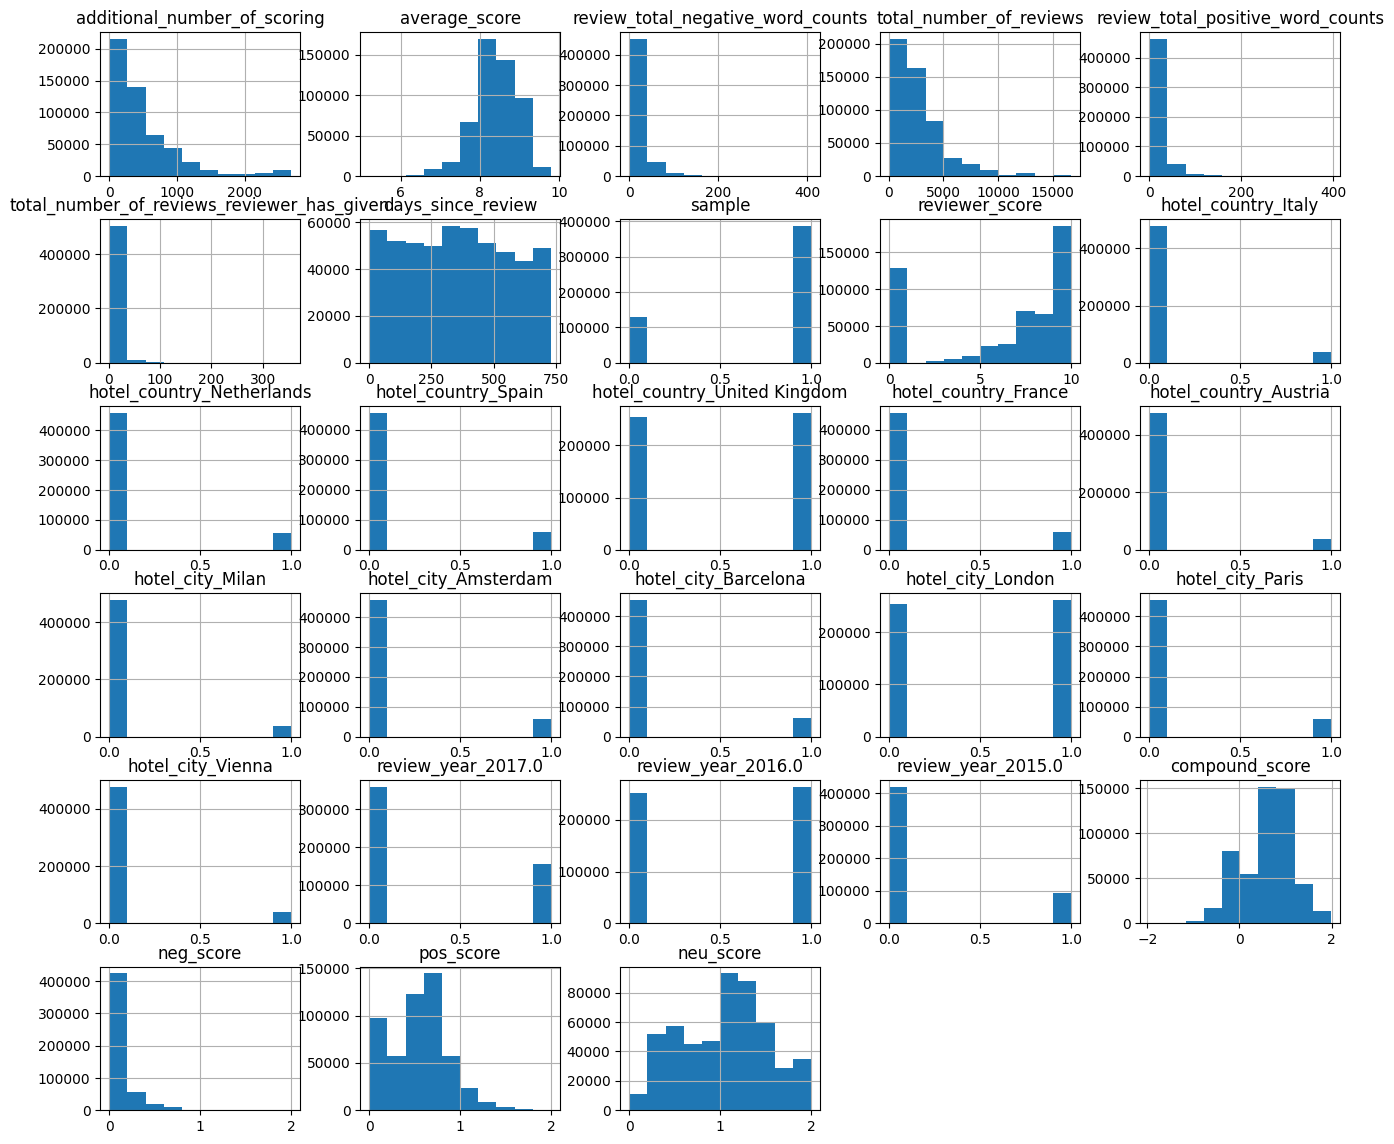

In [180]:
# ещё раз посмотрим на наши нестроковые признаки, чтобы примерно оценить их распределение
data.hist(figsize=(16,14));

<AxesSubplot: >

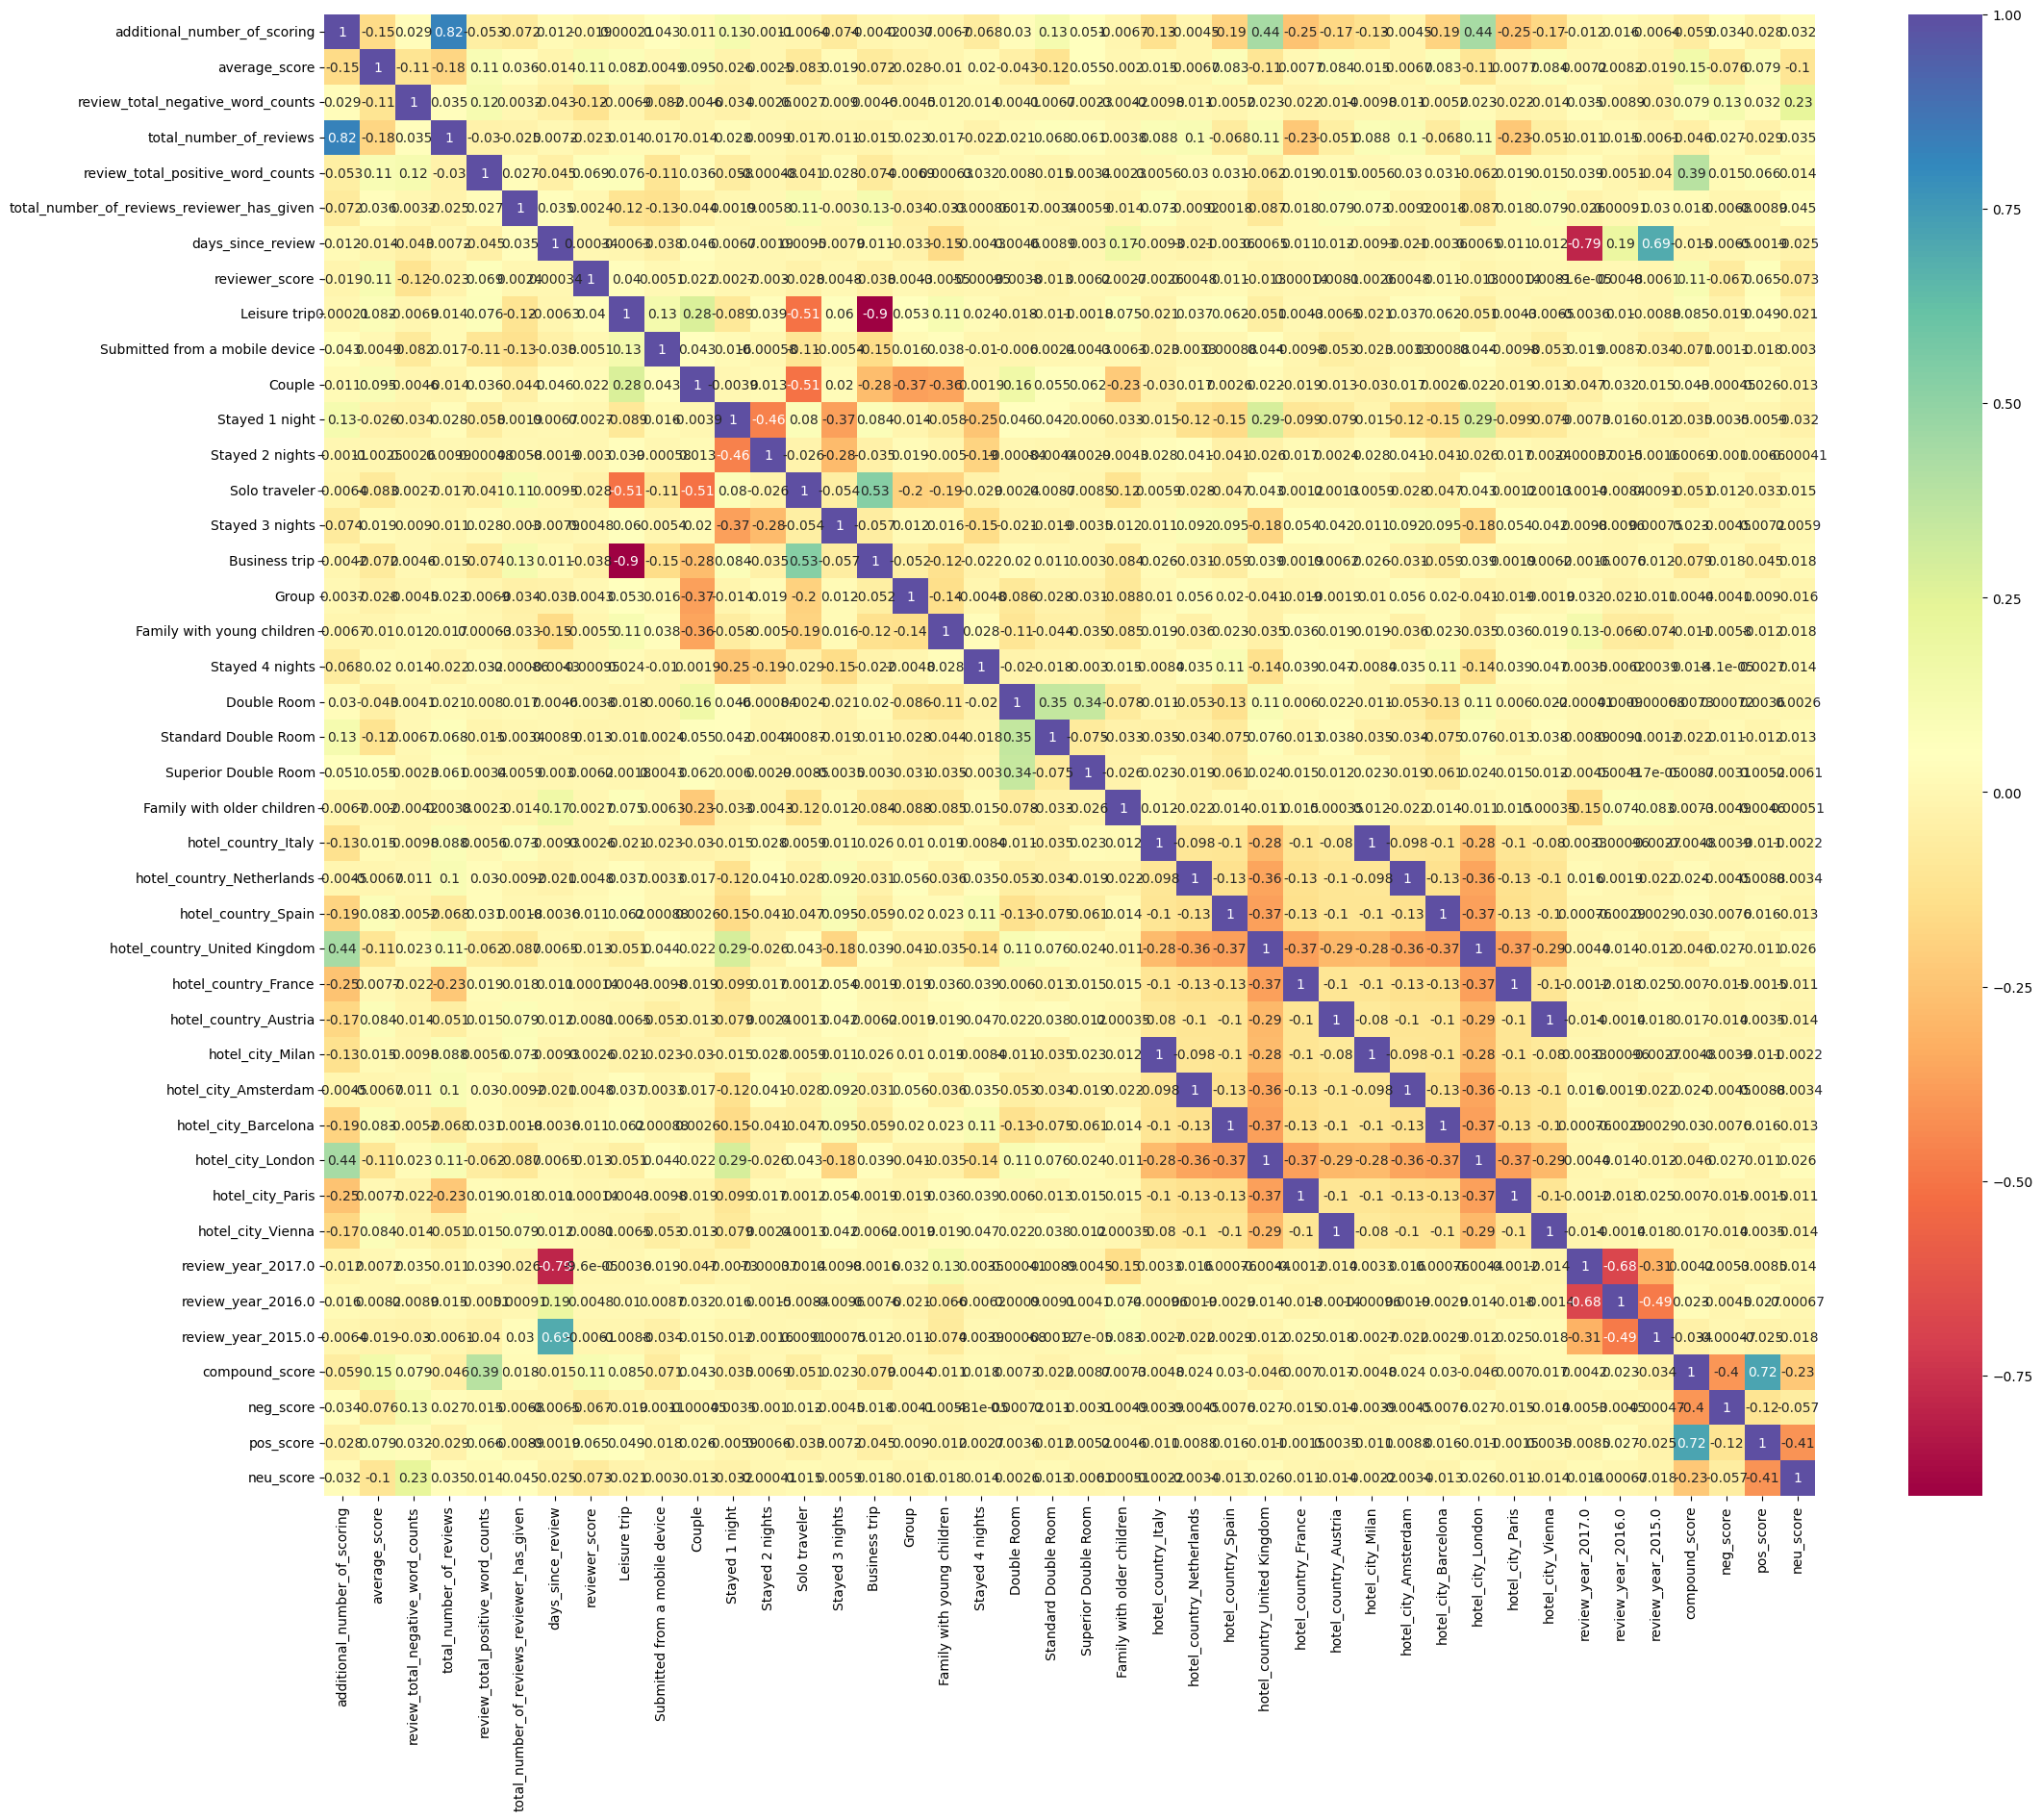

In [181]:
# оценим корреляцию признаков
plt.rcParams['figure.figsize'] = (25,20)
sns.heatmap(data.drop(['sample'], axis=1).corr(numeric_only = True), annot=True, cmap='Spectral')

In [182]:
# уберём несколько признаков с мультиколлинеарностью и небольшим влиянием
#data = data.drop(['review_year_2015', 'review_year_2016', 'review_year_2017', 'pos_score'], axis=1)

In [183]:
 # модель на признаках с dtypes "object" обучаться не будет, просто находим оставшиеся и удаляем
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
# ['hotel_name', 'tags']

In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 43 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   days_since_review                           515738 non-null  int64  
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   Leisure trip                                515738 non-null  bool   
 

In [185]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data['reviewer_score'].values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [186]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [187]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 42), (386803, 42), (386803, 41), (309442, 41), (77361, 41))

In [188]:
# создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [189]:
# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


In [190]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются
# метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12858291742615907


<AxesSubplot: >

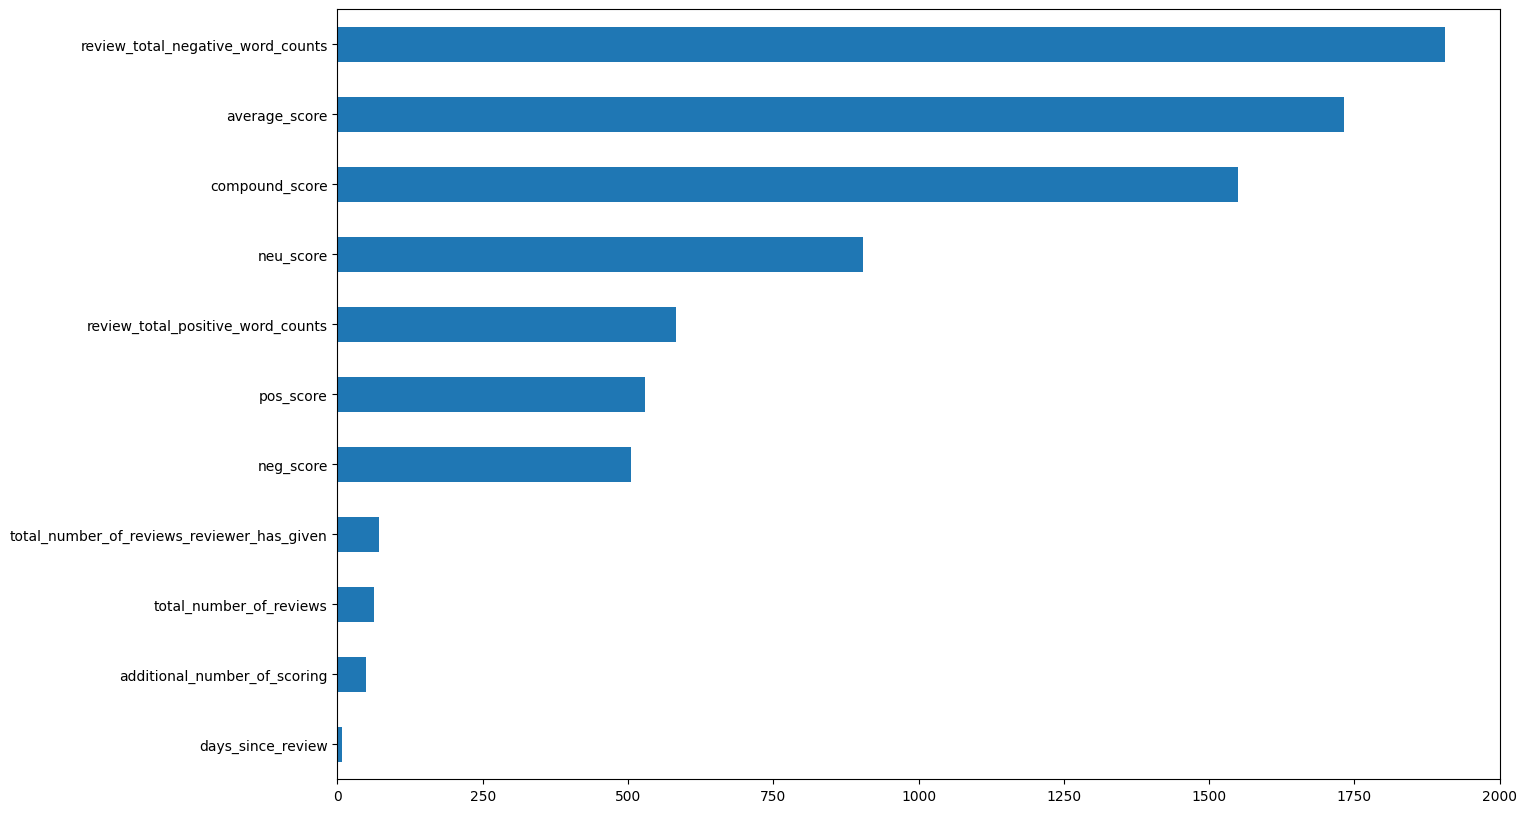

In [191]:
# для оценки значимости числовых признаков будем использовать тест ANOVA.
plt.rcParams['figure.figsize'] = (15,10)
imp_num = pd.Series(f_classif(X[num_col], y)[0], index = num_col)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<AxesSubplot: >

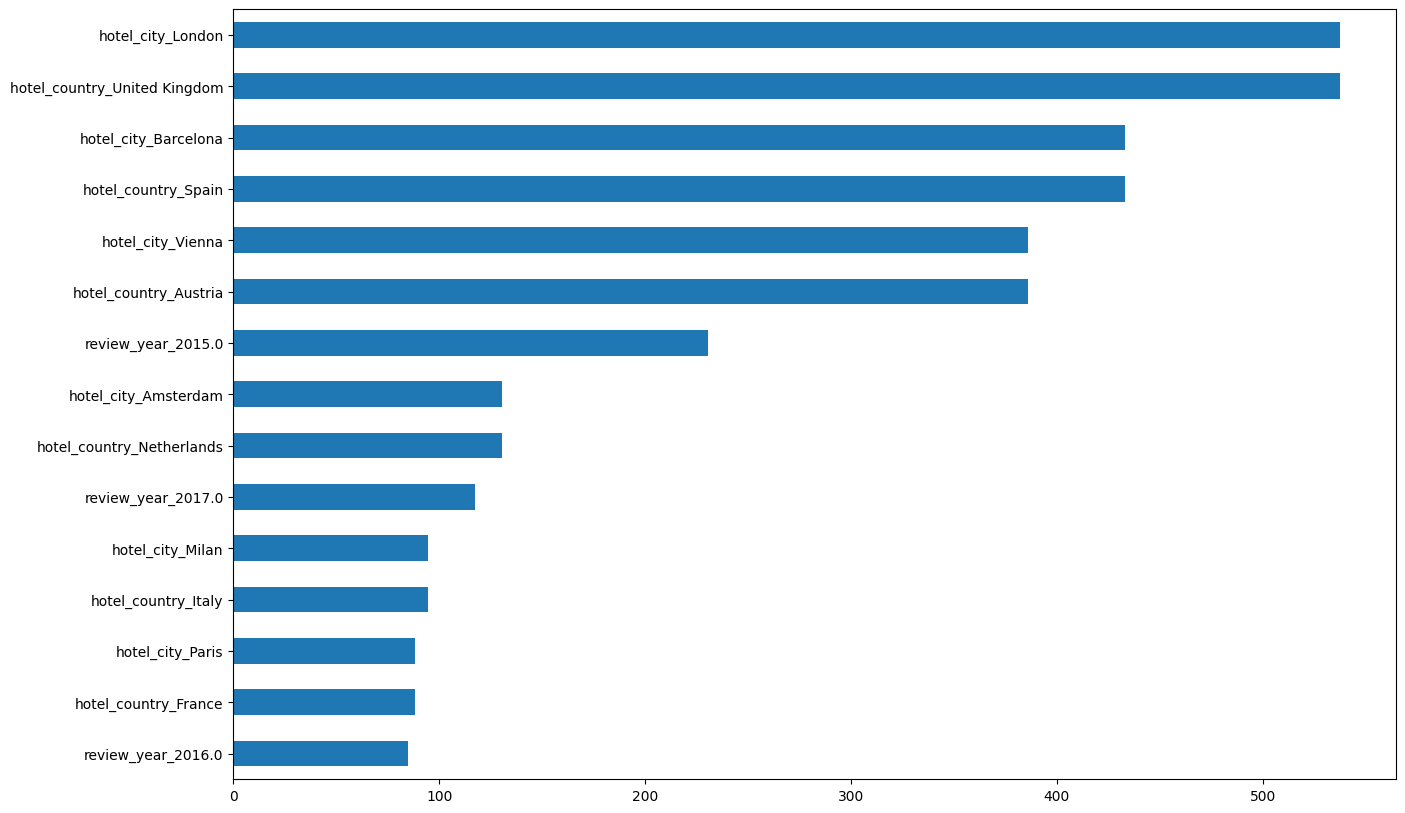

In [200]:
# для оценки значимости категориальных признаков будем использовать тест хи-квадрат
y=y.astype('int')

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_col], y)[0], index=bool_cat_col)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot: >

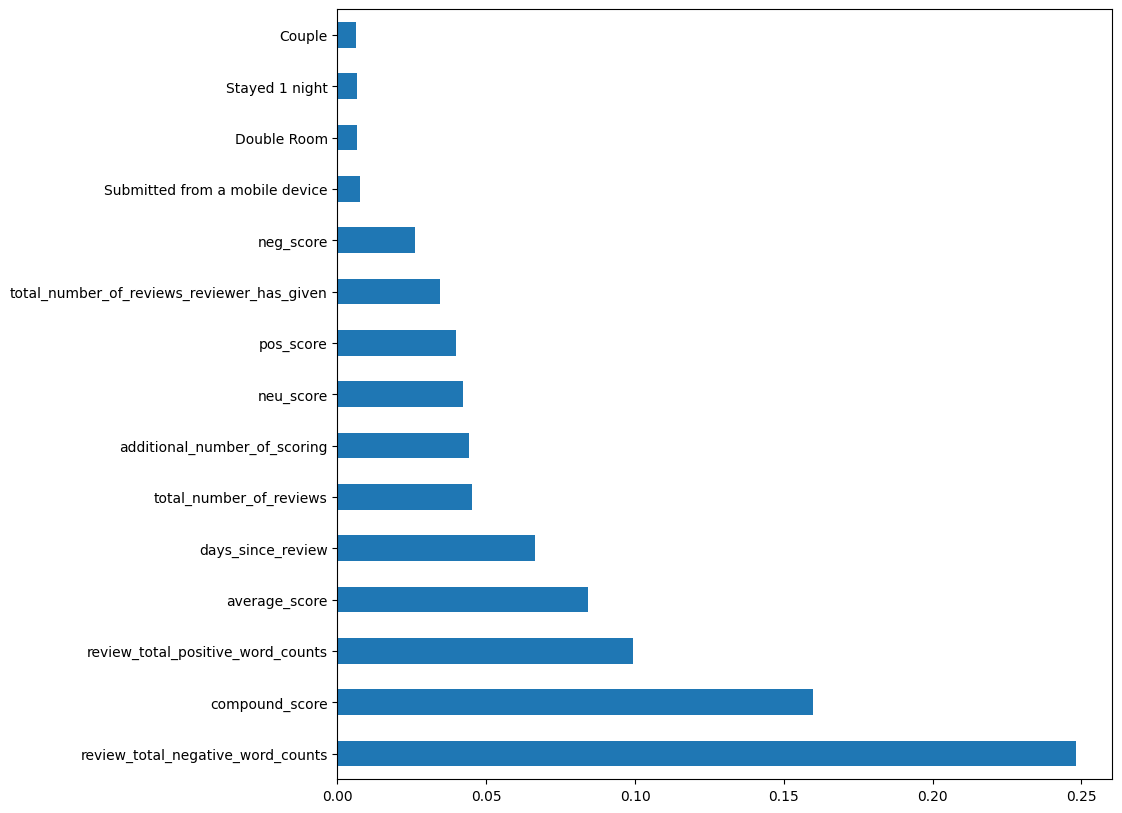

In [192]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [193]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,Leisure trip,Submitted from a mobile device,Couple,Stayed 1 night,Stayed 2 nights,Solo traveler,Stayed 3 nights,Business trip,Group,Family with young children,Stayed 4 nights,Double Room,Standard Double Room,Superior Double Room,Family with older children,hotel_country_Italy,hotel_country_Netherlands,hotel_country_Spain,hotel_country_United Kingdom,hotel_country_France,hotel_country_Austria,hotel_city_Milan,hotel_city_Amsterdam,hotel_city_Barcelona,hotel_city_London,hotel_city_Paris,hotel_city_Vienna,review_year_2017.0,review_year_2016.0,review_year_2015.0,compound_score,neg_score,pos_score,neu_score
88027,388,8.4,34,1708,44,26,203,0.0,False,False,False,False,False,True,False,True,False,False,True,True,False,True,False,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1.5116,0.064,0.680,1.256
60375,211,8.6,10,2923,9,23,637,0.0,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0.3752,0.508,0.735,0.757
83234,73,9.1,0,777,12,1,485,0.0,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.9313,0.000,0.788,0.212
77864,764,8.2,14,2996,53,19,207,0.0,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1.7072,0.026,0.953,1.021
51989,303,8.9,0,1110,5,6,479,0.0,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0.4404,0.000,0.744,0.256
67948,392,8.8,0,1803,4,24,577,0.0,True,False,False,True,False,True,False,False,False,False,False,True,True,False,False,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0.4939,0.000,0.762,0.238
123072,587,7.4,247,3869,7,19,371,0.0,True,True,False,False,True,False,False,False,False,True,False,False,False,False,False,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,-0.0886,0.220,0.693,1.087
8481,111,9.2,278,865,55,12,247,0.0,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1.7737,0.182,0.617,1.201
27077,724,8.0,24,3150,0,4,590,0.0,True,True,False,True,False,False,False,False,False,False,False,False,False,False,True,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,-0.6369,0.426,0.000,0.574
56385,950,8.6,19,3486,45,1,248,0.0,True,True,False,True,False,False,False,False,False,True,False,True,False,False,False,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1.2200,0.000,0.656,1.344


In [194]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [195]:
sample_submission.head()

,reviewer_score,id
0,8.651,488440
1,7.750,274649
2,8.317,374688
3,9.702,404352
4,9.619,451596


In [196]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished


In [197]:
predict_submission

array([8.885, 7.441, 8.446, ..., 8.042, 9.702, 6.926])

In [198]:
list(sample_submission)

['reviewer_score', 'id']

In [199]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.885,488440
1,7.441,274649
2,8.446,374688
3,9.658,404352
4,9.504,451596
5,9.288,302161
6,8.375,317079
7,7.699,13963
8,8.893,159785
9,8.180,195089
